In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import random
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
import os

# Ensure NLTK data is ready
nltk.download('stopwords', quiet=True)

In [24]:
# Import of clean lyrics df
df = pd.read_parquet(
    "data/pop_lyrics_nlp_clean.parquet"
)

In [25]:
# --- DECOUPLING SELECTION LOGIC AND DATABASE CREATION ---
# This cell creates the 'df_analysis' dataframe which serves as our final database for LDA.

# 1. Configuration
MAX_PER_YEAR = 1000  
START_YEAR = 1980
END_YEAR = 2022

# 2. Filter dataset
df_filtered = df.query("year >= @START_YEAR and year <= @END_YEAR")

# 3. Create 'Top' songs subset (most viewed)
df_top = (
    df_filtered
    .sort_values(["year", "views"], ascending=[True, False])
    .groupby("year", group_keys=False)
    .head(MAX_PER_YEAR)
).copy()
df_top["popularity"] = "top"

# 4. Create 'Flop' songs subset (least viewed)
df_flop = (
    df_filtered
    .sort_values(["year", "views"], ascending=[True, True])
    .groupby("year", group_keys=False)
    .head(MAX_PER_YEAR)
).copy()
df_flop["popularity"] = "flop"

# 5. Build Final Analysis Database
df_analysis = pd.concat([df_top, df_flop], ignore_index=True)
df_analysis["is_top"] = (df_analysis["popularity"] == "top").astype(int)

# 6. Safety Check
print(f"Database 'df_analysis' created successfully.")
print(f"Total documents: {len(df_analysis)}")
print(f"Popularity Breakdown:\n{df_analysis['popularity'].value_counts()}")
print("\nSample Data (titles):")
print(df_analysis[["title", "artist", "year", "popularity"]].head())

Database 'df_analysis' created successfully.
Total documents: 86000
Popularity Breakdown:
popularity
top     43000
flop    43000
Name: count, dtype: int64

Sample Data (titles):
                    title           artist  year popularity
0       New York New York    Frank Sinatra  1980        top
1       One Day At A Time      Cristy Lane  1980        top
2           Im Coming Out       Diana Ross  1980        top
3               Babooshka        Kate Bush  1980        top
4  Moscow English Version  Dschinghis Khan  1980        top


In [ ]:
# --- FULL NLP FEATURE ENGINEERING (Sentiment, Emotion, Readability, structural) ---

# 1. Initialize Sentiment (VADER)
analyzer = SentimentIntensityAnalyzer()

# 2. Load Emotion Lexicon (NRC)
nrc_path = "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
nrc_dict = defaultdict(list)
if os.path.exists(nrc_path):
    nrc_data = pd.read_csv(nrc_path, sep="\t", names=["word", "emotion", "association"])
    nrc_data = nrc_data[nrc_data["association"] == 1]
    for _, row in nrc_data.iterrows():
        nrc_dict[row["word"]].append(row["emotion"])
    print(f"✓ Loaded {len(nrc_dict)} words from NRC Lexicon.")
else:
    print("⚠ NRC Lexicon file not found. Emotion scores will be skipped.")

def get_nrc_scores(text):
    tokens = str(text).lower().split()
    counts = Counter()
    for t in tokens:
        for em in nrc_dict.get(t, []):
            counts[em] += 1
    total = sum(counts.values())
    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust", "positive", "negative"]
    if total == 0: return {e: 0 for e in emotions}
    return {e: counts[e]/total for e in emotions}

# 3. Calculate All Metrics
print("Engineering NLP features (this may take a minute)...")

# Sentiment
vader_scores = df_analysis['clean_lyrics'].apply(lambda x: analyzer.polarity_scores(str(x)))
df_analysis['sentiment_compound'] = vader_scores.apply(lambda x: x['compound'])
df_analysis['sentiment_pos'] = vader_scores.apply(lambda x: x['pos'])
df_analysis['sentiment_neg'] = vader_scores.apply(lambda x: x['neg'])
df_analysis['sentiment_neu'] = vader_scores.apply(lambda x: x['neu'])

# Emotion
nrc_scores = df_analysis['clean_lyrics'].apply(get_nrc_scores)
df_emotions = pd.json_normalize(nrc_scores)
df_analysis = pd.concat([df_analysis, df_emotions], axis=1)

# Readability
df_analysis['flesch_reading_ease'] = df_analysis['clean_lyrics'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
df_analysis['flesch_kincaid_grade'] = df_analysis['clean_lyrics'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))

# Structural
df_analysis['word_count'] = df_analysis['clean_lyrics'].str.split().str.len()
df_analysis['lexical_diversity'] = df_analysis['clean_lyrics'].apply(
    lambda x: len(set(str(x).split())) / len(str(x).split()) if len(str(x).split()) > 0 else 0
)

print(f"✓ Feature engineering complete for {len(df_analysis)} songs.")
print(f"Included features: Sentiment (4), Emotions (10), Readability (2), Structural (3)")

In [26]:
import re

def collapse_repetitions(text):
    if not isinstance(text, str):
        return text
    # Collapse immediate repetitions (e.g., "work work work" -> "work")
    # Matches a word (\b\w+\b) followed by one or more occurrences of the same word
    return re.sub(r'\b(\w+)(?:\s+\1\b)+', r'\1', text, flags=re.IGNORECASE)

print("Collapsing immediate repetitions in lyrics (e.g., 'yeah yeah' -> 'yeah')...")
df_analysis['clean_lyrics'] = df_analysis['clean_lyrics'].apply(collapse_repetitions)

Collapsing immediate repetitions in lyrics (e.g., 'yeah yeah' -> 'yeah')...


In [27]:
df.to_parquet(
    "data/pop_lyrics_to_model.parquet",
    index=False
)

In [28]:
df = pd.read_parquet(
    "data/pop_lyrics_to_model.parquet"
)

## LDA

In [ ]:
music_stopwords = [
    'like', 'thing', 'things', 'bit', 'little', 'let', 'lets',
    # Vocal fillers / ad-libs
    'yeah', 'yea', 'yah', 'ya',
    'la', 'na', 'nah',
    'oh', 'ooh', 'oooh', 'uh', 'uhh', 'huh', 'hmm',
    'hey', 'yo', 'aye', 'ayy',
    'da', 'di', 'dum', 'doo',

    # Generic pop references
    'baby', 'babe', 'girl', 'boy',
    'man', 'woman',
    'girls', 'boys',

    # Spoken / conversational fillers
    'well', 'right', 'okay', 'ok',
    'alright', 'alrighty',
    'really', 'just', 'still',
    'every', 'everything', 'something', 'nothing',

    # Common verbs (low semantic value in lyrics)
    'got', 'get', 'getting',
    'go', 'going', 'gone',
    'come', 'coming',
    'make', 'made',
    'see', 'seen',
    'say', 'said',
    'take', 'taken',
    'give', 'given',
    'keep', 'kept',
    'look', 'looking',
    'think', 'thinking',
    'tell', 'told',
    'know', 'knew',
    'feel', 'feeling',
    'want', 'wanted',
    'need', 'needed',
    'try', 'trying',

    # Time / quantity fillers
    'one', 'two', 'time', 'times',
    'day', 'night',
    'forever', 'never', 'ever',
    'always', 'sometimes',

    # Movement / direction
    'away', 'back', 'around',
    'down', 'up', 'out', 'in',

    # Modal / auxiliary verbs
    'would', 'could', 'should',
    'can', 'cant', 'cannot',
    'will', 'wont', 'dont', 'didnt',
    'im', 'ive', 'ill', 'youre', 'youve', 'youll',
    'weve', 'were', 'theyre',

    # Slang / contractions
    'wanna', 'gonna', 'gon',
    'ain', 'cause', 'cuz',
    'lemme', 'gimme',

    # Song-structure words
    'chorus', 'verse', 'hook',
    'repeat', 'bridge',

    # Generic emotional words (optional – remove if you want emotion topics)
    'love', 'heart',
    'feelin', 'feels',
    'dream', 'light', 'sky', 'star', 'shine', 'wings', 'soul'

]


In [10]:
# Advanced CountVectorizer for Lyrics
# 1. Expand stop words with generic music filler/generic verbs
custom_stopwords = list(nltk.corpus.stopwords.words('english')) + music_stopwords
# 2. Advanced configuration
cv = CountVectorizer(
    max_df=0.4,           # More strict: ignore words in >70% of songs (generic pop vocabulary)
    min_df=2,            # Ignore words appearing in <10 songs to reduce noise
    stop_words=custom_stopwords,
    ngram_range=(1, 2),   # Capture Bigrams (e.g., "heart break", "stay together")
    max_features=10000    # Focus on the 10k most meaningful terms/phrases
)

print(f"Advanced CountVectorizer configured:")
print(f"  - Vocabulary size limit: {cv.max_features}")
print(f"  - N-gram range: {cv.ngram_range}")
print(f"  - Custom stopwords added: {len(music_stopwords)} music-specific terms")

Advanced CountVectorizer configured:
  - Vocabulary size limit: 10000
  - N-gram range: (1, 2)
  - Custom stopwords added: 140 music-specific terms


### LDA on combined dataset

In [ ]:
# Construction of Document-Term matrix - all songs
dtm = cv.fit_transform(df_analysis['clean_lyrics'])

print(f"Matrice Document-Terme créée")
print(f"  - Forme: {dtm.shape} (documents x vocabulaire)")
print(f"  - {dtm.shape[0]} documents")
print(f"  - {dtm.shape[1]} mots dans le vocabulaire")
print(f"  - Type: {type(dtm)}")

Matrice Document-Terme créée
  - Forme: (86000, 10000) (documents x vocabulaire)
  - 86000 documents
  - 10000 mots dans le vocabulaire
  - Type: <class 'scipy.sparse._csr.csr_matrix'>


In [12]:
# LDA Concentration Tuning
# To reduce dispersion and increase concentration:
# 1. Lower doc_topic_prior (Alpha) -> Forces each document to pick fewer topics.
# 2. Lower topic_word_prior (Beta) -> Forces each topic to focus on fewer, more specific words.
# 3. Increase max_iter -> Allows the model to converge more strictly.

LDA = LatentDirichletAllocation(
    n_components=14,          # Reduced from 12 for stronger thematic clusters
    learning_offset=50.,
    random_state=42,
    learning_method="batch",
    max_iter=50,
    evaluate_every=1,
    doc_topic_prior=0.1,     # Extreme sparsity: each song will be strongly tied to 1-2 topics
    topic_word_prior=0.01,    # Extreme sparsity: makes words in topics more distinct
    n_jobs=-1
)

print(f"Model configured for high concentration:")
print(f"  - Topics: {LDA.n_components}")
print(f"  - Max iterations: {LDA.max_iter}")
print(f"  - Sparsity priors (Alpha/Beta): {LDA.doc_topic_prior} / {LDA.topic_word_prior}")

Model configured for high concentration:
  - Topics: 14
  - Max iterations: 50
  - Sparsity priors (Alpha/Beta): 0.1 / 0.01


In [13]:
# Entraînement du modèle LDA global
print("Entraînement du modèle LDA sur l'ensemble du dataset...")
# LDA.fit handles the fitting, and returns itself.
LDA.fit(dtm)
print("✓ Entraînement terminé !")

# Assignation des topics aux documents
print("Calcul des probabilités de topics pour chaque chanson...")
topic_results = LDA.transform(dtm)
df_analysis['Topic'] = topic_results.argmax(axis=1)

print("Distribution des topics dans le dataset complet :")
print(df_analysis['Topic'].value_counts().sort_index())

Entraînement du modèle LDA sur l'ensemble du dataset...
✓ Entraînement terminé !
Calcul des probabilités de topics pour chaque chanson...
Distribution des topics dans le dataset complet :
Topic
0      3447
1      1370
2      1329
3      3452
4      4435
5      2756
6      1529
7      1936
8     14364
9     17260
10     6745
11     1642
12     4305
13    21430
Name: count, dtype: int64


In [14]:
# Extraction du premier topic
single_topic = LDA.components_[0]
print(f"Topic 0 - Distribution sur {len(single_topic)} mots")

Topic 0 - Distribution sur 10000 mots


In [15]:
top_ten_words = single_topic.argsort()[-20:]

In [16]:
# Conversion des indices en mots
print("\nTop 10 mots du Topic 0:")
for index in top_ten_words:
    word = cv.get_feature_names_out()[index]
    prob = single_topic[index]
    print(f"  - {word:<20} (probabilité: {prob:.4f})")


Top 10 mots du Topic 0:
  - trust                (probabilité: 2372.2558)
  - word                 (probabilité: 2530.6181)
  - mean                 (probabilité: 2789.0984)
  - find way             (probabilité: 2805.0100)
  - understand           (probabilité: 3300.5771)
  - words                (probabilité: 3353.4278)
  - hand                 (probabilité: 3546.9827)
  - show                 (probabilité: 3631.1030)
  - set                  (probabilité: 3690.9153)
  - way way              (probabilité: 3789.0100)
  - anything             (probabilité: 4506.7459)
  - friend               (probabilité: 4583.5324)
  - find                 (probabilité: 5160.9057)
  - waiting              (probabilité: 5265.8675)
  - care                 (probabilité: 5556.6406)
  - help                 (probabilité: 6049.0566)
  - walk                 (probabilité: 6340.8337)
  - yes                  (probabilité: 7590.7404)
  - free                 (probabilité: 8383.9996)
  - way                  

In [18]:
# Boucle sur tous les topics
print("=" * 70)
print("TOPICS DÉCOUVERTS PAR LDA")
print("=" * 70)

for i, topic in enumerate(LDA.components_):
    print(f"\nTOPIC #{i}")
    print("-" * 70)
    top_words = [cv.get_feature_names_out()[idx] for idx in topic.argsort()[-40:]]
    print("Top 40 mots:", ', '.join(top_words))

print("\n" + "=" * 70)

TOPICS DÉCOUVERTS PAR LDA

TOPIC #0
----------------------------------------------------------------------
Top 40 mots: lead, please, forget, used, thank, easy, yes yes, much, talk, talking, speak, cool, low, believe, pray, ask, set free, might, gotta, anymore, trust, word, mean, find way, understand, words, hand, show, set, way way, anything, friend, find, waiting, care, help, walk, yes, free, way

TOPIC #1
----------------------------------------------------------------------
Top 40 mots: nobody knows, wah, name name, jesus jesus, nobody else, bounce, watch, weh, gal, dat, nobody nobody, runnin, shot, shoot, shame, wow, call, mmm mmm, breathe, work work, ooo, pon, gun, gyal, nuh, shake shake, inna, round round, jah, yuh, mmm, lady, run run, name, shake, work, dem, round, nobody, run

TOPIC #2
----------------------------------------------------------------------
Top 40 mots: six, blow, thought, party party, smile, hand, hold hand, holy holy, boom boom, seven, arms, comin, ready ready

<Figure size 1400x600 with 0 Axes>

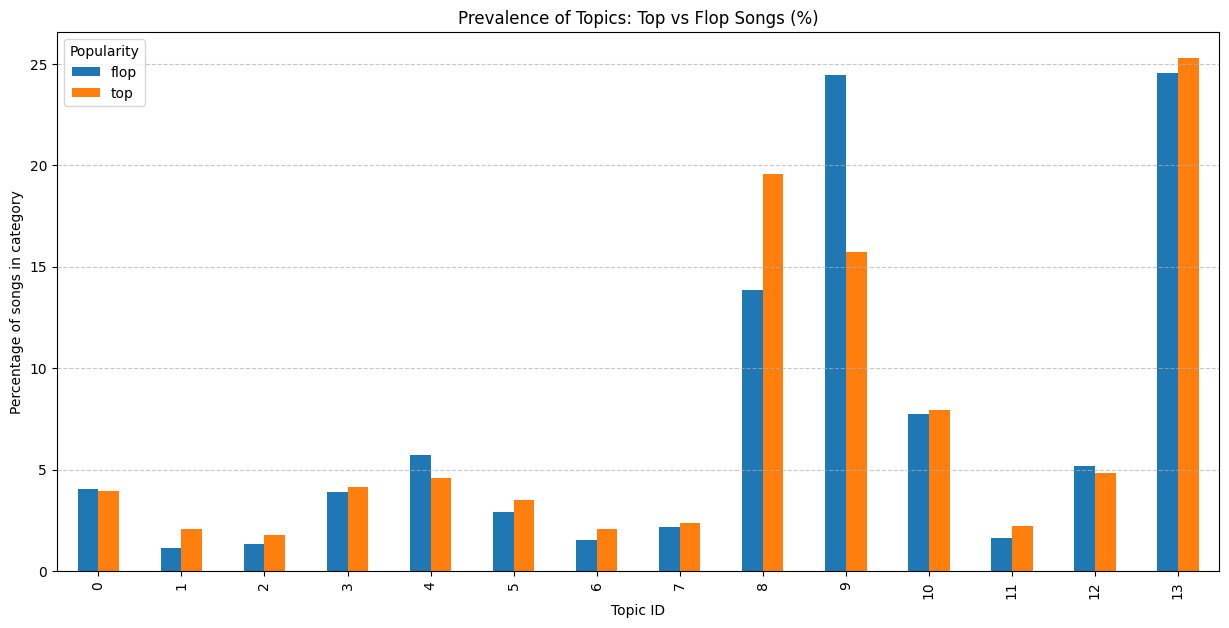


Chi-square test of independence between Topic and Popularity:
  - Chi2: 1543.08
  - P-value: 0.0000e+00
  => The distribution of topics is significantly different between Top and Flop songs.


In [19]:
# Comparative topic distribution: Top vs Flop
plt.figure(figsize=(14, 6))

# Calcul des pourcentages par groupe pour une comparaison équitable
topic_counts = df_analysis.groupby(['popularity', 'Topic']).size().unstack(fill_value=0)
topic_pcts = topic_counts.div(topic_counts.sum(axis=1), axis=0) * 100

topic_pcts.T.plot(kind='bar', figsize=(15, 7))
plt.title("Prevalence of Topics: Top vs Flop Songs (%)")
plt.xlabel("Topic ID")
plt.ylabel("Percentage of songs in category")
plt.legend(title="Popularity")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Statistical check (Chi-square) if interested in significance
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(topic_counts)
print(f"\nChi-square test of independence between Topic and Popularity:")
print(f"  - Chi2: {chi2:.2f}")
print(f"  - P-value: {p:.4e}")
if p < 0.05:
    print("  => The distribution of topics is significantly different between Top and Flop songs.")
else:
    print("  => No significant difference in topic distribution found.")

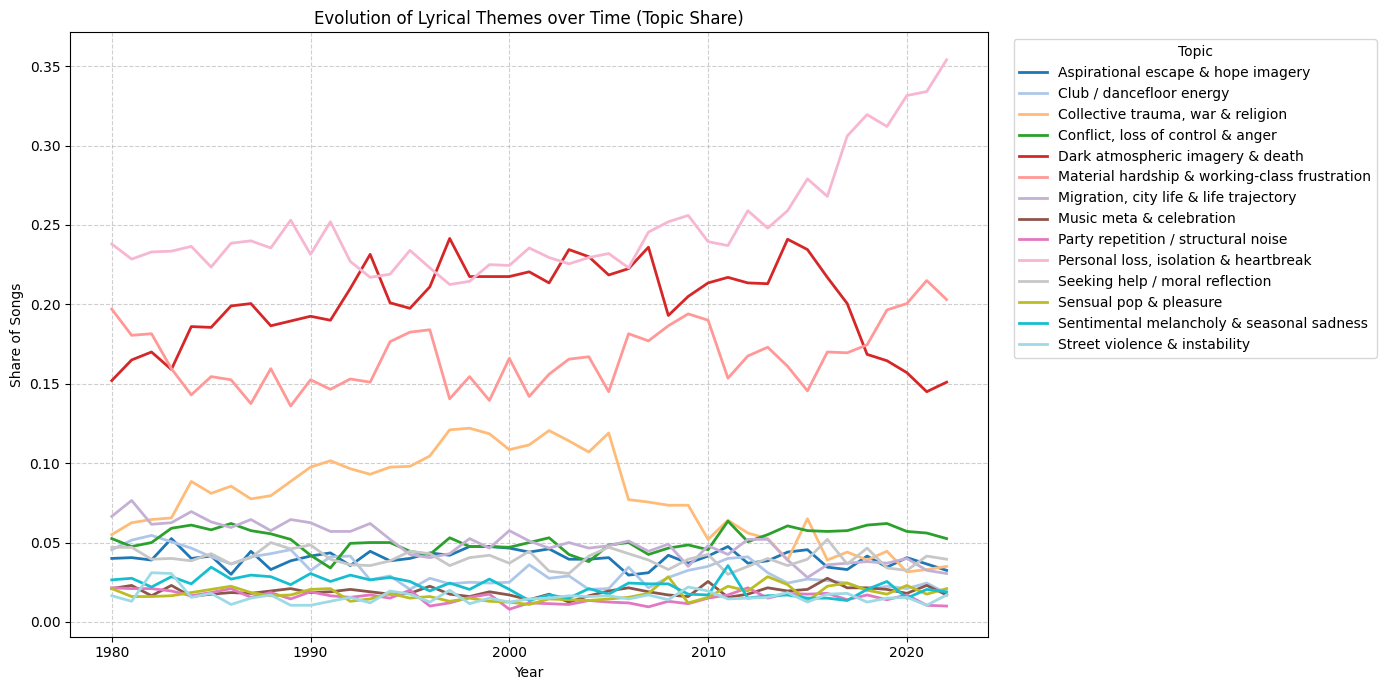

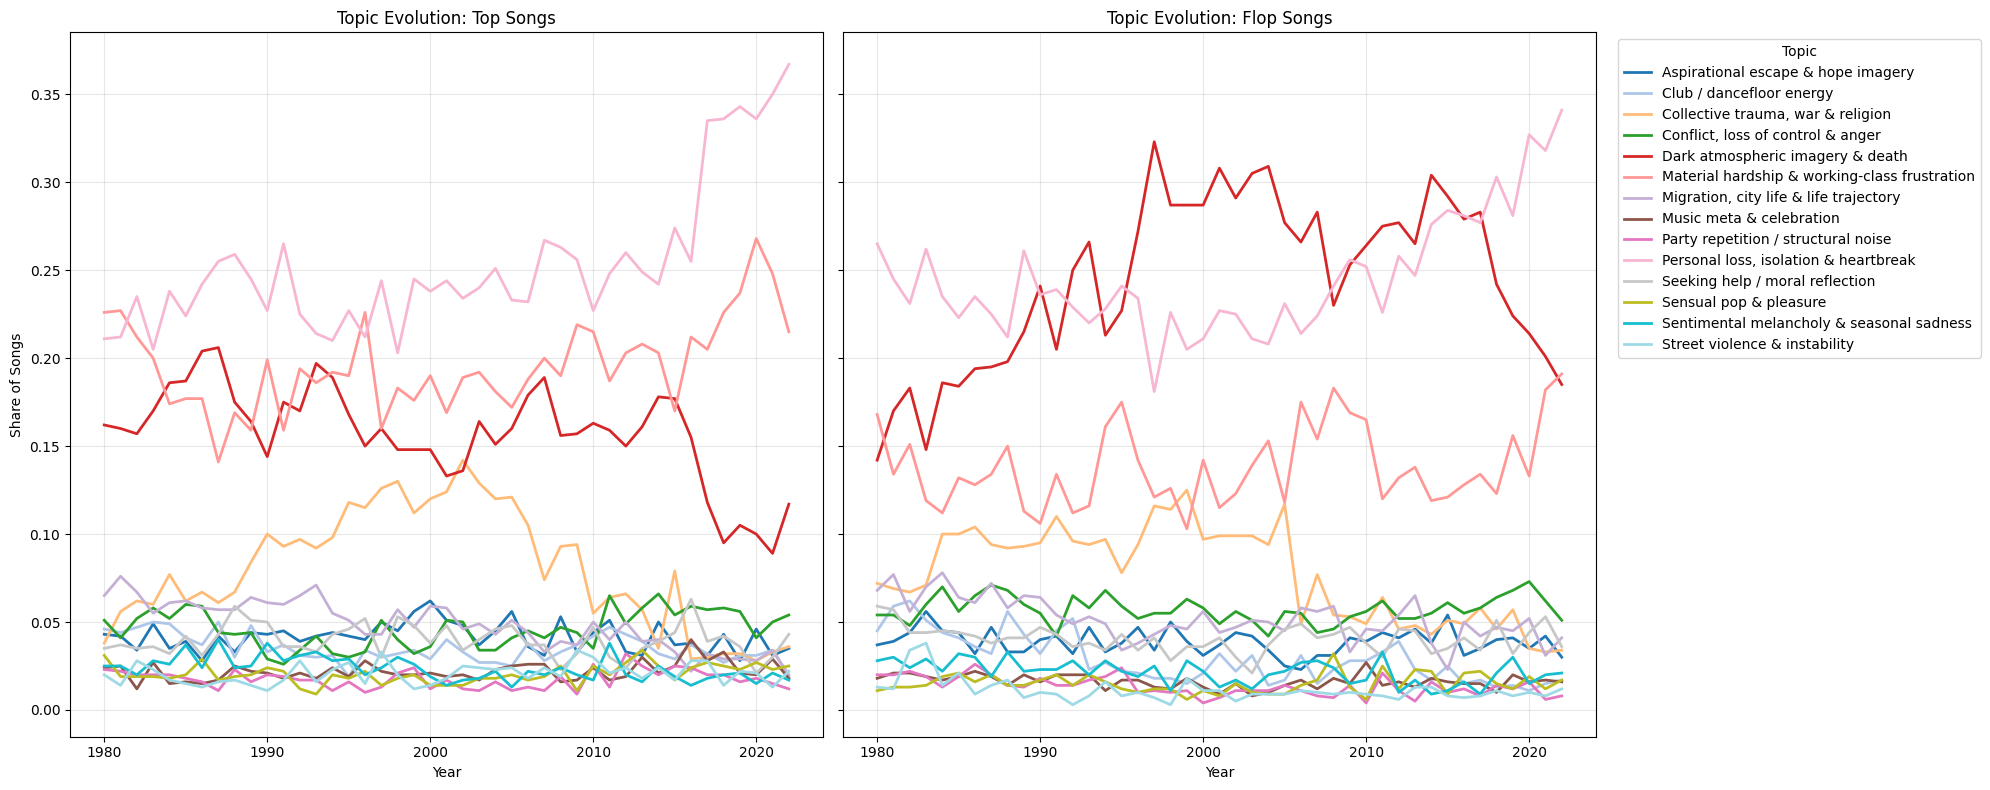

In [21]:
topic_labels = {
    0: "Seeking help / moral reflection",
    1: "Street violence & instability",
    2: "Party repetition / structural noise",
    3: "Aspirational escape & hope imagery",
    4: "Conflict, loss of control & anger",
    5: "Club / dancefloor energy",
    6: "Sensual pop & pleasure",
    7: "Sentimental melancholy & seasonal sadness",
    8: "Material hardship & working-class frustration",
    9: "Dark atmospheric imagery & death",
    10: "Collective trauma, war & religion",
    11: "Music meta & celebration",
    12: "Migration, city life & life trajectory",
    13: "Personal loss, isolation & heartbreak",
}

# Use the DTM and LDA model from previous steps
doc_topic = LDA.transform(dtm)  # shape: (n_docs, n_topics)

# Dominant topic per song
dominant_topic = doc_topic.argmax(axis=1)
dominant_score = doc_topic.max(axis=1)

# Using our combined dataset df_analysis
df_topics = df_analysis.copy()
df_topics["dominant_topic_id"] = dominant_topic
df_topics["dominant_topic_label"] = df_topics["dominant_topic_id"].map(topic_labels)
df_topics["dominant_topic_score"] = dominant_score

# Keep full topic mixture columns
for k in range(LDA.n_components):
    df_topics[f"topic_{k}_prob"] = doc_topic[:, k]

# Time chart logic
year_topic_counts = (
    df_topics.dropna(subset=["year"])
             .groupby(["year", "dominant_topic_label"])
             .size()
             .reset_index(name="count")
)

# Convert to share per year
year_totals = year_topic_counts.groupby("year")["count"].transform("sum")
year_topic_counts["share"] = year_topic_counts["count"] / year_totals

pivot_share = year_topic_counts.pivot(index="year", 
                                      columns="dominant_topic_label", 
                                      values="share").fillna(0).sort_index()

plt.figure(figsize=(14, 7))
# Use 'tab20' colormap to ensure 14 distinct colors
pivot_share.plot(ax=plt.gca(), linewidth=2, colormap='tab20')
plt.title("Evolution of Lyrical Themes over Time (Topic Share)")
plt.xlabel("Year")
plt.ylabel("Share of Songs")
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Evolution by popularity category (Top vs Flop)
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

for i, pop in enumerate(["top", "flop"]):
    subset = df_topics[df_topics["popularity"] == pop]
    counts = subset.groupby(["year", "dominant_topic_label"]).size().reset_index(name="count")
    totals = counts.groupby("year")["count"].transform("sum")
    counts["share"] = counts["count"] / totals
    
    pivot = counts.pivot(index="year", columns="dominant_topic_label", values="share").fillna(0)
    # Use 'tab20' here as well
    pivot.plot(ax=axes[i], linewidth=2, legend=(i==1), colormap='tab20')
    
    axes[i].set_title(f"Topic Evolution: {pop.capitalize()} Songs")
    axes[i].set_xlabel("Year")
    axes[i].grid(True, alpha=0.3)

axes[0].set_ylabel("Share of Songs")
if axes[1].get_legend():
    axes[1].legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [31]:
# --- PREPARATION FOR XGBOOST ---
# 1. Encoding dominant topic (One-Hot Encoding)
# This adds 14 binary columns 'topic_id_0', 'topic_id_1', etc.
df_encoded = pd.get_dummies(df_topics, columns=['dominant_topic_id'], prefix='topic_id')

# 3. Export to Parquet for the XGBoost Notebook
output_path = "data/pop_lyrics_with_topics.parquet"
df_encoded.to_parquet(output_path)

print(f"Dataset for XGBoost created successfully: {output_path}")
print(f"Shape: {df_encoded.shape}")
print(f"Topic features added: { [col for col in df_encoded.columns if 'topic_id_' in col or 'prob' in col] }")

Dataset for XGBoost created successfully: data/pop_lyrics_with_topics.parquet
Shape: (86000, 39)
Topic features added: ['topic_0_prob', 'topic_1_prob', 'topic_2_prob', 'topic_3_prob', 'topic_4_prob', 'topic_5_prob', 'topic_6_prob', 'topic_7_prob', 'topic_8_prob', 'topic_9_prob', 'topic_10_prob', 'topic_11_prob', 'topic_12_prob', 'topic_13_prob', 'topic_id_0', 'topic_id_1', 'topic_id_2', 'topic_id_3', 'topic_id_4', 'topic_id_5', 'topic_id_6', 'topic_id_7', 'topic_id_8', 'topic_id_9', 'topic_id_10', 'topic_id_11', 'topic_id_12', 'topic_id_13']
